In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

from numba import jit

In [2]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psix(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [3]:

def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 1000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psix(0, xs) + 0.60 * psix(1, xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [4]:

def multMatrizes(M, us, O = -5, L = 5, T = 10):
    N = 1000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)
    
    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = us #V(x,u(t))
    #V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()

    return np.matmul(np.linalg.inv(matrizA), matrizB)

In [5]:
# Gradiente e função objetivo

def ExactSolution(M, T = 1000, L = 5):
    N = 1000

    xs = np.linspace(-5, L, M)
    ts = np.linspace(0, N/100, T)
    
    psiExato = np.zeros((M, N)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.01):
        for j in np.arange(0, 10, 0.01):
            psiExato[r][int(round(j*100,1))] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1
    return psiExato

def Objetivo(y, x, psi, psiExato):
    A = np.zeros((1000,1000))
    B = np.zeros((1000,1000))
    A = multMatrizes(M = 1000, us = x[0])
    B = multMatrizes(M = 1000, us = x[1])
    return ((np.linalg.norm(np.array(psiExato[0:1000, y])-np.array(psi)))**2+
            (np.linalg.norm(np.array(psiExato[0:1000, y+1])-np.array(np.matmul(A,psi))))**2+
            (np.linalg.norm(np.array(psiExato[0:1000, y+2])-np.array(np.matmul(np.matmul(B,A),psi))))**2)


def ObjetivoS(y, x, psi, psiExato, alpha, d): #Função para a seção áurea
    z = x + alpha * d
    A = np.zeros((1000,1000))
    B = np.zeros((1000,1000))
    A = multMatrizes(M = 1000, us = z[0])
    B = multMatrizes(M = 1000, us = z[1])
    return ((np.linalg.norm(np.array(psiExato[0:1000, y])-np.array(psi)))**2+
            (np.linalg.norm(np.array(psiExato[0:1000, y+1])-np.array(np.matmul(A,psi))))**2+
            (np.linalg.norm(np.array(psiExato[0:1000, y+2])-np.array(np.matmul(np.matmul(B,A),psi))))**2)


def SecaoAurea(y, x, psi, psiExato, d):
    eps = 0.0000001
    a = 0
    b = 1
    xa = b - 0.618*(b-a)
    xb = a + 0.618*(b-a)
    fxa = ObjetivoS(y, x, psi, psiExato, xa, d)
    fxb = ObjetivoS(y, x, psi, psiExato, xb, d)
    
    while(b - a > eps):
        if(fxa < fxb):
            b = xb
            xb = xa
            xa = b - 0.618*(b - a)
            fxb = fxa
            fxa = ObjetivoS(y, x, psi, psiExato, xa, d)
        else:
            a = xa
            xa = xb
            xb = a + 0.618*(b - a)
            fxa = fxb
            fxb = ObjetivoS(y, x, psi, psiExato, xb, d)
            
    xp = (a+b)/2
    return xp

#Avaliação do gradiente

def gradiente(x, tempo, psi, psiExato):
    h = 0.0000001
    grad = []
    
    for i in range(len(x)):
        xh = x.copy()
        xh[i] = xh[i] + h
        dx = (Objetivo(tempo, xh, psi, psiExato)-Objetivo(tempo, x, psi, psiExato))/h
        grad.append(dx)
    return grad


def hessiana(x, tempo, psi, psiExato):
    n = len(x)
    h = 0.001
    Hx = np.zeros((n,n))
    gradfx = gradiente(x, tempo, psi, psiExato)
    
    for i in range(len(x)):
        xh = x.copy()
        xh[i] = xh[i] + h
        gradfxh = gradiente(xh, tempo, psi, psiExato)
        
        for j in range(len(x)):
            Hx[i,j] = ((gradfxh[j] - gradfx[j])/h)
    
    return Hx

In [6]:
import random

psi = np.zeros((1000,1000))
psi_f = np.zeros((1000,1000))
psi_g = psi_f.astype(complex)
psi = CrankNicolson(M = 1000, O = -5, L = 5, T = 10)
psiExato = ExactSolution(M = 1000)

In [7]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psii(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psiii(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x.real)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [8]:
@jit
def MetodoGradNewton(x, tempo, psi, psiExato):
    
    eps = 0.1
    SequenciaPontos = [x]
    
    errox = eps + 1
    xant = x.copy()
    
    errof = eps + 1
    FuncF = Objetivo(tempo, x, psi, psiExato)
    
    k = 0
    kmax = 10
    normagrad = eps + 1
    
    CP = ''
    
    while(CP == ''):
        #print(x)
        d = -1*np.array(gradiente(x, tempo, psi, psiExato))
        #d = -1*(np.matmul(np.linalg.inv(hessiana(x, tempo, psi, psiExato)),gradiente(x, tempo, psi, psiExato)))
        alpha = SecaoAurea(tempo, x, psi, psiExato, d)
        x = x + alpha * d
        
        errox = np.linalg.norm(xant - x)
        xant = x.copy()
        if(errox <= eps):
            CP = CP + 'Erro x'
        normagrad = np.linalg.norm(d)
        if(normagrad <= eps):
            CP = CP + 'Norma Gradiente'
        FuncFx = Objetivo(tempo, x, psi, psiExato)
        errof = abs(FuncF - FuncFx)
        FuncF = FuncFx
        if(errof <= eps):
            CP = CP + 'Erro F'
        if(k >= kmax):
            CP = 'Numero de iteracoes'
            
        k += 1
        SequenciaPontos.append(x)
        
    xOtimo = x
    return SequenciaPontos, k, xOtimo, CP

x = []
x.append(random.uniform(-5, 5))
x.append(random.uniform(-5, 5))
tempo = 0
resultado = MetodoGradNewton(x, tempo, psi, psiExato)
print('iteracoes = ', resultado[1])
print('x = ', resultado[2])
print('Criterio de parada: ', resultado[3])

/tmp/ipykernel_3502/3592765336.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "MetodoGradNewton" failed type inference due to: Untyped global name 'Objetivo': Cannot determine Numba type of <class 'function'>

File "../../../../../tmp/ipykernel_3502/3592765336.py", line 11:
<source missing, REPL/exec in use?>

  @jit
/home/gabriel/miniconda3/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "MetodoGradNewton" was compiled in object mode without forceobj=True.

File "../../../../../tmp/ipykernel_3502/3592765336.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/gabriel/miniconda3/lib/python3.9/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.r

iteracoes =  11
x =  [-802.22341977 -319.54101544]
Criterio de parada:  Numero de iteracoes


[-0.3143751826145005, 0.27751894938469324]
Iteracao =  1
Otimo =  [-800.60448874 -320.17776071]
Criterio =  Numero de iteracoes
---------------
[-800.6044887361678, -0.7088034118472812]
Iteracao =  2
Otimo =  [-423.21629818  168.3669826 ]
Criterio =  Numero de iteracoes
---------------
[-423.2162981764865, 2.258871950992848]
Iteracao =  3
Otimo =  [ 69.0516916  103.35393346]
Criterio =  Numero de iteracoes
---------------
[69.05169160404509, 4.410614377391074]
Iteracao =  4
Otimo =  [69.7554222  10.72730949]
Criterio =  Erro F
---------------
[69.75542219685427, 4.602847621477336]
Iteracao =  5
Otimo =  [16.658396    4.50505875]
Criterio =  Numero de iteracoes
---------------
[16.658395996643694, 1.8999722616071537]
Iteracao =  6
Otimo =  [9.46742185 9.7201712 ]
Criterio =  Numero de iteracoes
---------------
[9.46742184977457, 0.8826520829811582]
Iteracao =  7
Otimo =  [12.09200518 10.70519448]
Criterio =  Numero de iteracoes
---------------
[12.092005177298683, -4.2031637668130895]
I

Iteracao =  62
Otimo =  [12.59084481 11.04176727]
Criterio =  Erro F
---------------
[12.590844811738297, -0.7970486682536979]
Iteracao =  63
Otimo =  [12.86733119 10.75484326]
Criterio =  Numero de iteracoes
---------------
[12.86733119021999, 1.0594866804728484]
Iteracao =  64
Otimo =  [12.58793443 11.02521991]
Criterio =  Numero de iteracoes
---------------
[12.58793442880691, 2.9037282837184133]
Iteracao =  65
Otimo =  [12.75149795 11.1197393 ]
Criterio =  Erro F
---------------
[12.751497949550817, -3.9600296146936897]
Iteracao =  66
Otimo =  [13.33299246 10.42657529]
Criterio =  Numero de iteracoes
---------------
[13.332992459241789, 0.3903356565981184]
Iteracao =  67
Otimo =  [12.59200896 10.99751729]
Criterio =  Numero de iteracoes
---------------
[12.592008964910852, 0.3760429625771575]
Iteracao =  68
Otimo =  [12.9243747  11.12699751]
Criterio =  Numero de iteracoes
---------------
[12.92437469567516, -0.4375446580374929]
Iteracao =  69
Otimo =  [13.14148926 11.04042355]
Cri

Iteracao =  122
Otimo =  [14.73288665 12.4010725 ]
Criterio =  Numero de iteracoes
---------------
[14.732886649238578, 4.458988254152089]
Iteracao =  123
Otimo =  [15.20320453 12.70352102]
Criterio =  Numero de iteracoes
---------------
[15.203204530950593, 1.8935829254644663]
Iteracao =  124
Otimo =  [15.9249795  12.18236866]
Criterio =  Numero de iteracoes
---------------
[15.924979497934379, 1.7285582905604269]
Iteracao =  125
Otimo =  [15.86793599 12.10814798]
Criterio =  Numero de iteracoes
---------------
[15.867935992479206, -4.27003577229685]
Iteracao =  126
Otimo =  [16.84582466 10.75918169]
Criterio =  Numero de iteracoes
---------------
[16.845824657424988, -1.4095049269781468]
Iteracao =  127
Otimo =  [15.95059087 11.31468925]
Criterio =  Numero de iteracoes
---------------
[15.950590867730575, 1.1191167294998756]
Iteracao =  128
Otimo =  [15.91915873 12.27868904]
Criterio =  Numero de iteracoes
---------------
[15.919158732071608, -4.896839238125729]
Iteracao =  129
Otimo

[14.835332128423381, 2.0349971648573106]
Iteracao =  181
Otimo =  [13.87665199 11.77313845]
Criterio =  Numero de iteracoes
---------------
[13.876651990824755, -0.823877048244146]
Iteracao =  182
Otimo =  [14.29283675 11.30834524]
Criterio =  Numero de iteracoes
---------------
[14.29283675001299, -3.62176304479216]
Iteracao =  183
Otimo =  [14.18864504 10.69848513]
Criterio =  Numero de iteracoes
---------------
[14.188645041069364, 3.853790290433585]
Iteracao =  184
Otimo =  [12.93135961 11.78109132]
Criterio =  Numero de iteracoes
---------------
[12.931359614710507, -3.421559638541668]
Iteracao =  185
Otimo =  [14.09434863 10.74734862]
Criterio =  Numero de iteracoes
---------------
[14.09434863409245, 0.08538108572178604]
Iteracao =  186
Otimo =  [13.10307221 11.02900298]
Criterio =  Numero de iteracoes
---------------
[13.103072207662297, 0.32586798796392014]
Iteracao =  187
Otimo =  [13.07804291 11.08497161]
Criterio =  Numero de iteracoes
---------------
[13.078042914452372, -

[11.173435769893656, 1.0689598205609965]
Iteracao =  243
Otimo =  [11.28424901 10.20646724]
Criterio =  Erro F
---------------
[11.28424901130793, 0.8295743359463126]
Iteracao =  244
Otimo =  [11.29243281 10.17528325]
Criterio =  Erro F
---------------
[11.292432809382934, 4.31672248492648]
Iteracao =  245
Otimo =  [11.15115067 10.35797941]
Criterio =  Erro F
---------------
[11.151150668843893, -4.5752629051397475]
Iteracao =  246
Otimo =  [11.34365308 10.26154885]
Criterio =  Numero de iteracoes
---------------
[11.343653079097216, 2.242524833276245]
Iteracao =  247
Otimo =  [11.21604421 10.34526682]
Criterio =  Erro F
---------------
[11.216044206768643, 1.0018453360014545]
Iteracao =  248
Otimo =  [11.3644966  10.22572219]
Criterio =  Erro F
---------------
[11.364496602289348, -0.9457039418988256]
Iteracao =  249
Otimo =  [11.25686834 10.28724928]
Criterio =  Erro F
---------------
[11.256868337594154, -2.061718216221957]
Iteracao =  250
Otimo =  [11.34869415 10.22035495]
Criterio

KeyboardInterrupt: 

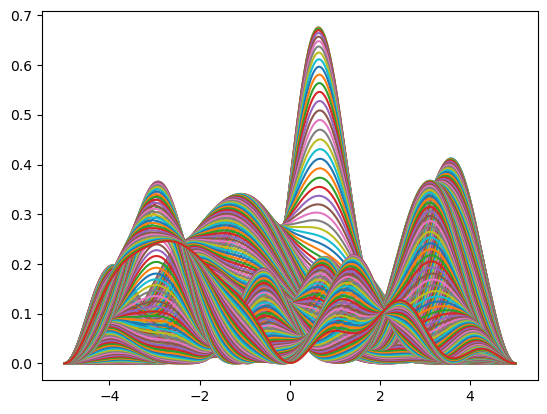

In [9]:
u1 = []
u2 = []
vetor = []
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
tempo = 0
xs = np.linspace(-5,5,1000)

while tempo < 999:
    print(u1)
    psi_g[0:1000, tempo] = psi[0:1000, tempo]
    plt.plot(xs, np.absolute(psi[0:1000, tempo])**2)
    u2 = MetodoGradNewton(u1, tempo, psi, psiExato)
    print("Iteracao = ", (tempo+1))
    print("Otimo = ", u2[2])
    print("Criterio = ", u2[3])
    print("---------------")
    D = multMatrizes(M = 1000, us = u2[2][0])
    psi = np.matmul(D, psi)
    tempo += 1
    u1 = []
    u1.append(u2[2][0])
    u1.append(random.uniform(-5, 5))

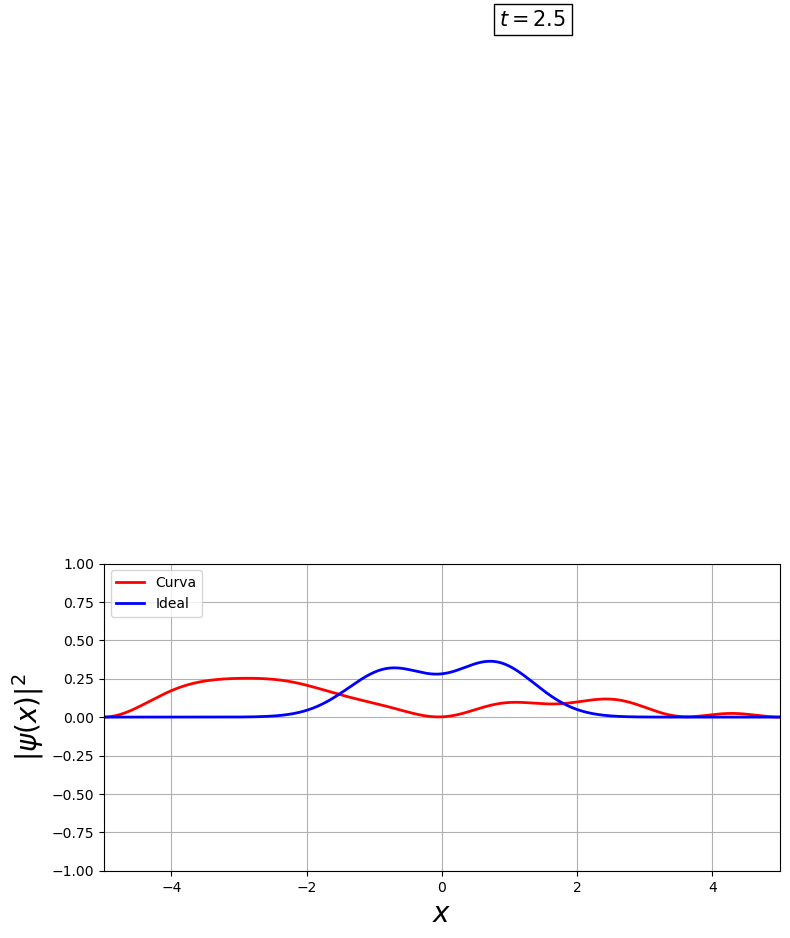

In [10]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    xs = np.linspace(-5,5,1000)
    ln1.set_data(xs, np.absolute(psi_g[0:1000,i-1])**2)
    ln2.set_data(xs, np.absolute(psiExato[0:1000,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Curva')
ln2, = plt.plot([], [], 'b-', lw=2, markersize=8, label='Ideal')
time_text = ax.text(0.85, 4.5, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(-1, 1)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=250, interval=200)
ani.save('QuantControl3.gif',writer='pillow',fps=10,dpi=100)